# Lecture 7: Risk Backtesting and Forecasting

So far, we have learned how to take a series of risk factors, map them to a loss distribution and use that distribution to define various risk measures (most notably, VaR and CVaR). This lecture will cover how to control, that is to review and assess the quality of a risk models you are using by backtesting or stress testing. This is done with the goal of overall improvement. 

The main topics of discussion are the following:

 1. Forecasting
 2. Backtesting
 3. VaR estimation: a practical example
 


In [1]:
#Importing standard libraries

import numpy as np
from matplotlib import pyplot as plt 
import scipy as sci
import pandas as pd

## Forecasting 

In simple terms, forecasting is the act of taking historical data, assuming a model which you fit to that data by optimizing for certain parameters $\vec{\theta}$, and using that model to try and _predict_ the future. 

One (rather terrible) example is using a polynomial fitting (see lecture 4) to predict stock prices, as will be done in the following code block:

In [2]:
from pandas_datareader import data ## This import allows us to import stock price data from yahoo finance
from scipy.optimize import curve_fit ## Function to fit dataset to function

def get_stock_price(ticker, start='2016-01-01', end='2020-12-31',price_type = 'Adj Close'): ##function from lecture 1
    return data.DataReader(ticker,'yahoo',start,end)[price_type]

training_data = list(get_stock_price('GOOG')) #google price data as a list

q_eq_5 = lambda t,a,b,c,d,e,f: a + b*t + c*(t**2) + d*(t**3) + e*(t**4) + f*(t**5) #polynomial function of order 5

model = curve_fit(q_eq_5,list(range(len(training_data))),training_data) #estimated beta values (params of best fit)

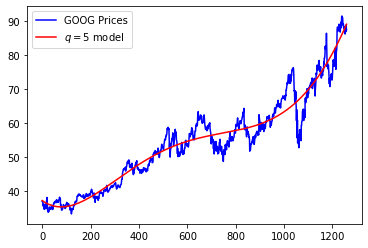

In [3]:
plt.plot(training_data,color='blue',label='GOOG Prices') #plotting stock data
plt.plot([q_eq_5(i,*model[0]) for i in range(len(training_data))],color='r',label=r'$q = 5$ model')#plotting the model
plt.legend()

As you can see, this polynomial fit follows the trend of GOOG prices from new year 2016 to new year 2021. Let us try to use this model to forecast prices throughout 2021 and 2022.

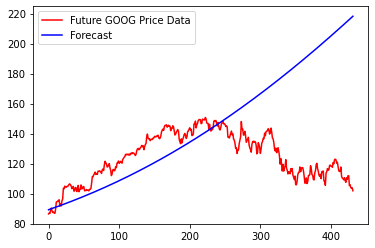

In [4]:
test_data = list(get_stock_price('GOOG', start='2021-01-01', end='2022-09-20')) ##Future data 

forecast = [q_eq_5(i,*model[0]) for i in range(len(training_data), len(training_data)+len(test_data))] #Forecast

plt.plot(test_data, color='r',label='Future GOOG Price Data')
plt.plot(forecast, color='b', label='Forecast')
plt.legend()

As you can see, the trend forecast is not too bad for the first ~200 days after the training period but gets increasingly worse later on. In fact, let us plot the error over time

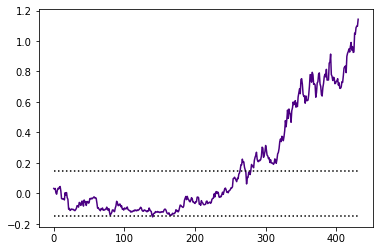

In [5]:
resid = [(forecast[i] - test_data[i])/test_data[i] for i in range(len(test_data))]

plt.plot(resid,color='indigo')
plt.plot([0.15 for i in range(len(test_data))],linestyle='dotted',color='black')
plt.plot([-0.15 for i in range(len(test_data))],linestyle='dotted', color='black')

Setting a 15 percent tolerance, we can see that the error greatly starts to diverge from the tolerance as time goes on. 

The data in the "training period" (i.e 2016-2021) is known as the _in-sample_ data. As you can see the model does a very good job of estimating the trend there. Although, the story is different for the _out-of-sample_ data (i.e the "testing period", 2021-2022).

Another example of estimating and forecasting is recording the height of highschool students and fitting it to a normal distribution with $\vec{\theta} = \{\mu,\sigma^2\}$ (that is, estimating the parameters) and using this model to forecast the distribution of height in the next 20 years (weird example as height tends to be constant in such short timeframes).

## Backtesting

In simplest terms, backtesting is the act of testing the out-of-sample fit of a model. One does that by applying the model to historical data and then reviewing the adequacy of the model. The procedure for backtesting VaR is:

 - estimation of a parametric VaR model based on sample data
 - forecastof out-of-sample values as VaR barrier 
 - comparison of predicted VaR-barriers and realized values (i.e number of VaR exceedences -- see lecture 6)
 - evaluation of different quality characteristics of VaR forecast

Or in simpler terms:

First, you must divide your sample data into "training data" and "testing data". You then use the training data to employ one of VaR estimation (see lecture 6). After that, you must use some model such as ARCH or GARCH to forecaste the VaR beyond the training data. Apply that forecasting model to the testing data and see when VaR exceedences occur. And finally, compare that to the actual VaR exceedences. This comparison should determine the quality of the forecasting model.

The "quality" of a VaR model is described by what is called _Unconditional Coverage_. A low quality model can have one of two issues: 1. VaR exceedance happens way more than anticipated. This would result in a risk tolerance that is too high (and may lose an account manager a lot of money). 2. VaR exceedences happen way less than anticipated. This would result in an account manager having too low of a risk apetite, and therefore sacrificing potential profits. 

The following are examples of an innappropriately high and low VaR, respectively:


<table><tr>
<td> <img src="assets/pussy.png"style="width: 400;"/> </td>
<td> <img src="assets/yolo.png" style="width: 400;"/> </td>
</tr></table>

The first asset manager will miss out on some good trades or holdings, whilst the second will likely YOLO the account (literally only exceeds VaR once in four years lol). 

The proper way to test unconditional coverage is to see if percentage of expected VaR exceedences $\approx$ confidence level $\alpha$. It is called unconditional coverage because we are not interested in _when_ these VaR exceedances happen, but simply how many times (again, see Lecture 6).

